In [145]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from data.data_processing import ProcessInput
from data import data_importation
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Modelling Premier League results with gradient boosting

This notebook describes an attempt to predict the result of a PL team's upcoming games by learning from historical fixtures. The machine learning framework that will be used is **gradient boosted trees**, specifically [Microsoft's LightGBM](https://github.com/Microsoft/LightGBM).

**Data sources**:

- Fixture history for PL teams since 1990 scraped from World Football: http://www.worldfootball.net/teams.
- Stadium locations from Google Maps' API: https://maps.googleapis.com/maps/api/geocode
- (*Future*) Fan sentiment from Reddit

**Contents**:

1. [Gradient boosted trees](#gbm)
2. [The data set](#datset)
    1. [Processor class](#processor)
    2. [Target variable](#target)
    3. [Interesting features](#features)
    4. [Dimensionality reduction](#dimreduction)
    5. [Stratified split](#split)
3. [Training the model](#train)
4. [Predicting](#predict)

## 1. Gradient boosted trees <a name="gbm"></a>

Gradient boosted trees (GBTs) are a powerful machine learning framework for working with relational, tabular data. A detailed explanation of how they work under the hood can be found [here](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/), but a brief account of their advantages would be:

- Simple, concise APIs mean **implementation is easy**
- They **don't require any feature scaling** due to being tree based
- **Excellent performance** on relational data, almost always better than random forests
- Relatively **fast training times** (depending on specific implementation)
- Is strong on both **classication and regression** tasks

However, the downsides to consider are:

- Non-linearity means they **can't extrapolate**
- **Prone to overfitting**, but they are a lot of hyperparameters to mediate

LightGBM is a particular implementation of GBTs. It has a few notable advantages over other GBT packages not limited to:

- **Leaf wise splitting**, resulting in potentially better results and faster training times.

<img src="https://raw.githubusercontent.com/Microsoft/LightGBM/master/docs/_static/images/leaf-wise.png" alt="drawing" width="500"/>

- **Categorical handling** that removes the need for one-hot encoding and hence the risk of overfitting. Detailed in the LightGBM documentation:

> LightGBM sorts the histogram (for a categorical feature) according to its accumulated values (sum_gradient / sum_hessian) and then finds the best split on the sorted histogram.

- **Native missing-values handling**, removing the need for additional preprocessing or dropping potentially meaningful information


## 2. The data set <a name="dataset"></a>

Data set is scraped using code in the `data/data_importation.py` module. 

Currently only interested in the Premier League, so limit the data to that for now

In [81]:
# Main data file path - doesn't have to exist if the data is going to be updated
file_path = os.path.join('data', 'training_data', 'world_football_fixture_history.csv')

# Choose whether the data needs updating (has there been any more matches since last time?)
update_data = False

if update_data == True:
    
    # Get the year to start loading from. If there is already some data, pick up where it leaves off
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        start_year = int(df['date'].max()[:4])
        print('Existing data found starting from {}'.format(start_year))
    else:
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))
        start_year = 1990  # 89/90 season
        
    # Call the scraping function to update
    data_importation.scrape_training_data(start_year, file_path)
    
else:
    
    # Otherwise read the existing data path
    df = pd.read_csv(file_path)
    
# Trim to Premier League only
df = df[df['competition'].str.contains('Premier League')]
df.head(5)

,round,date,opponent,result,competition,season,season_number,team,round_number,team_score,opposition_score,team_ht_score,opposition_ht_score,team_at_home,team_win,team_draw,team_loss
0,1. Round,1989-08-18,Manchester City,3:1 (1:1),Premier League 1989/1990,1989 / 1990,0,liverpool-fc,1.0,3,1,1,1,1,True,False,False
1,2. Round,1989-08-22,Aston Villa,1:1 (1:0),Premier League 1989/1990,1989 / 1990,0,liverpool-fc,2.0,1,1,1,0,0,False,True,False
2,3. Round,1989-08-25,Luton Town,0:0 (0:0),Premier League 1989/1990,1989 / 1990,0,liverpool-fc,3.0,0,0,0,0,0,False,True,False
3,5. Round,1989-09-08,Derby County,3:0 (0:0),Premier League 1989/1990,1989 / 1990,0,liverpool-fc,4.0,3,0,0,0,0,True,False,False
4,4. Round,1989-09-11,Crystal Palace,9:0 (3:0),Premier League 1989/1990,1989 / 1990,0,liverpool-fc,5.0,9,0,3,0,1,True,False,False


### 2.1.  Processor class <a name="processor"></a>

The code makes use of the `ProcessInput` class defined in `data/data_processing.py` for most of the data processing required.

**Feature extraction** - use predefined transformation method to add in additional features including:

- A scaled version of the date to act as a weight column, giving more weight to more recent games
- Extracting the day of week from the data column, as well as days since last game
- Home/away flag
- Add the current win streak and undefeated streaks as integers
- Add form data for the team of interest and their opposition (# wins in last 5 - # losses)
- Some metrics such as points per game this season (PPG)
- Create a beatability index for each oppositon based on previous performance against them

In [82]:
processor = ProcessInput()
print('\'processor\' methods:\n')
methods = [func for func in dir(processor) if (callable(getattr(processor, func))) & ('__' not in func)]
for method in methods:
    print('\t{}'.format(method))

'processor' methods:

	append_travel_data
	calculate_opponents_form
	calculate_streaks
	drop_features
	fit
	fit_transform
	get_beatability_index
	get_season_data
	process_date
	process_result
	stratified_train_test
	transform


In [83]:
df = processor.fit_transform(df)
df.head()

,date,opponent,result,competition,season,season_number,team,round_number,team_score,opposition_score,...,PPG,season_points,GFPG,GAPG,GDPG,recent_form,season_points_opponent,PPG_opponent,GDPG_opponent,recent_form_opponent
0,1.0,45,3,Premier League 2018/2019,2018 / 2019,29,everton-fc,38.0,0,0,...,1.026316,39.0,0.105263,0.078947,0.026316,0.0,41.0,1.078947,0.078947,0.0
1,1.0,17,3,Premier League 2018/2019,2018 / 2019,29,tottenham-hotspur,38.0,0,0,...,1.078947,41.0,0.131579,0.052632,0.078947,0.0,39.0,1.026316,0.026316,0.0
2,1.0,19,3,Premier League 2018/2019,2018 / 2019,29,southampton-fc,38.0,0,0,...,0.947368,36.0,0.026316,0.052632,-0.026316,0.0,35.0,0.921053,-0.210526,0.0
3,1.0,30,3,Premier League 2018/2019,2018 / 2019,29,fulham-fc,38.0,0,0,...,0.921053,35.0,0.026316,0.131579,-0.105263,0.0,36.0,0.947368,-0.026316,0.0
4,1.0,18,3,Premier League 2018/2019,2018 / 2019,29,newcastle-united,38.0,0,0,...,0.947368,36.0,0.026316,0.052632,-0.026316,0.0,35.0,0.921053,-0.105263,0.0


**Choose a team to model**

Data is available for most PL teams but at the moment feels best to model one at a time

In [84]:
team = 'liverpool-fc'
df = df[df['team'].str.contains(team)]
df.drop(['team'], inplace=True, axis=1)

# Also separate future fixtures
future_df = df[df['result'] == 3]
df = df[df['result'] != 3]

# Result dictionary
result_dict = {0: 'Draw', 1: 'Win', 2: 'Loss', 3: 'Future fixture'}

### 3.2 Target variable <a name="target"></a>

The target variable this model will train on is the result of the fixture, `result`. 

Count the target classes - how well does this team usually do?

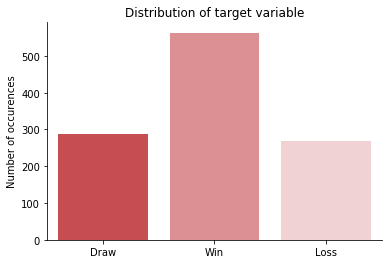

In [85]:
fig, ax = plt.subplots(1, 1, figsize=[6, 4])
target_summary = df['result'].value_counts().sort_values()
palette = sns.diverging_palette(11, 10)
sns.barplot(x=target_summary.index, y=target_summary, ax=ax, palette=palette)
ax.set_xticklabels(pd.Series(ax.get_xticks()).map(result_dict).values)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Number of occurences')
ax.set_title('Distribution of target variable')
plt.show()

### 3.3. Interesting features <a name="features"></a>

**Average performance vs specific opposition**

A beatability index gives an indication of how the teaam plays against each team in the premier league.

For any given opposition, it is simply:

\begin{align}
b_{opp} = \frac{games\ won_{opp}}{total\ games_{opp}} - \frac{games\ lost_{opp}}{total\ games_{opp}}
\end{align}



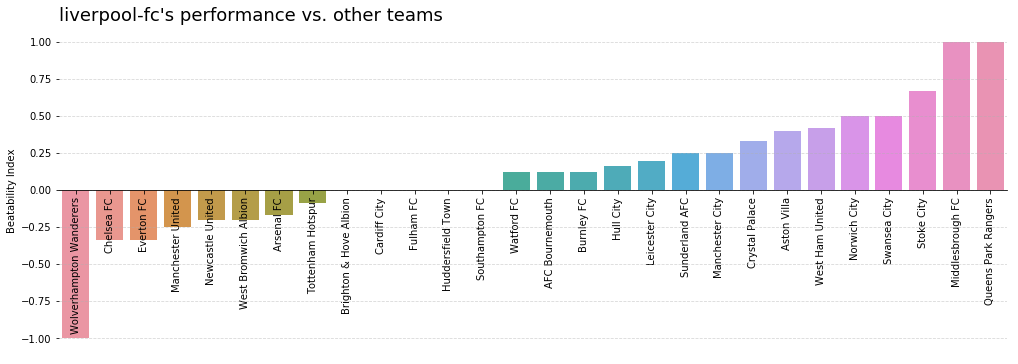

In [86]:
fig, ax = plt.subplots(1, 1, figsize=[17, 6])
beatability_df = processor.beatability_df[processor.beatability_df['team'] == team]
barplot = sns.barplot(
    x='opponent', 
    y='beatability_index', 
    data=beatability_df.sort_values(by='beatability_index'),
    ax=ax
)

ax.spines['bottom'].set_position('zero')
for label in barplot.get_xticklabels():
    label.set_rotation(90)
    
for spine in ['top', 'left', 'right']:
    ax.spines[spine].set_visible(False)

ax.grid(axis='y', linestyle='--', alpha=.5)
    
ax.set_ylabel('Beatability Index')
ax.set_xlabel('')
ax.set_title('{}\'s performance vs. other teams'.format(team), fontsize=18, horizontalalignment='left', x=0)
plt.show()

**Performance as season progresses**

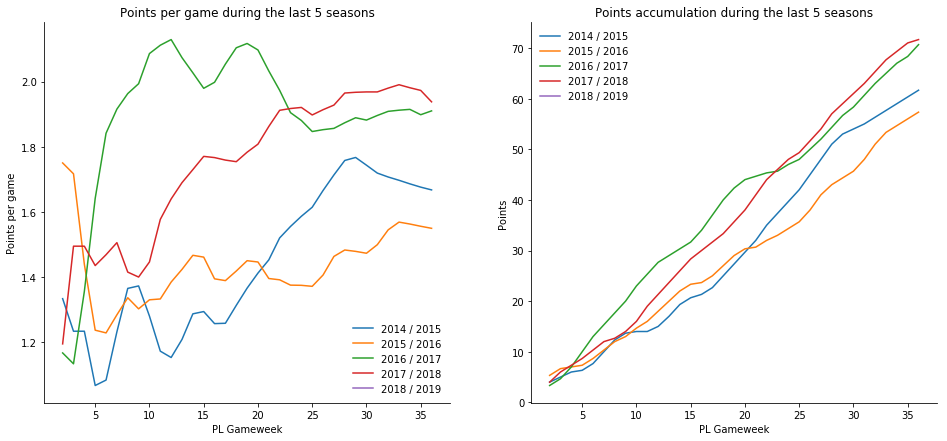

In [87]:
seasons_to_plot = 5
rolling_avg_games = 3

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[16,7])

for season in range(df['season_number'].max()+1 - seasons_to_plot, df['season_number'].max()+1):
    season_df = df[df['season_number'] == season]
    season_years = season_df['season'].mode().values[0]
    axs[0].plot(season_df['round_number'], season_df['PPG'].rolling(rolling_avg_games).mean(), label=season_years)
    axs[1].plot(season_df['round_number'], season_df['season_points'].rolling(rolling_avg_games).mean(), label=season_years)
    
axs[0].set_ylabel('Points per game')   
axs[0].set_title('Points per game during the last {} seasons'.format(seasons_to_plot))
axs[1].set_ylabel('Points') 
axs[1].set_title('Points accumulation during the last {} seasons'.format(seasons_to_plot))
for ax in axs:
    ax.legend(frameon=False)
    ax.set_xlabel('PL Gameweek')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.show()

 **Correlation of features with label**

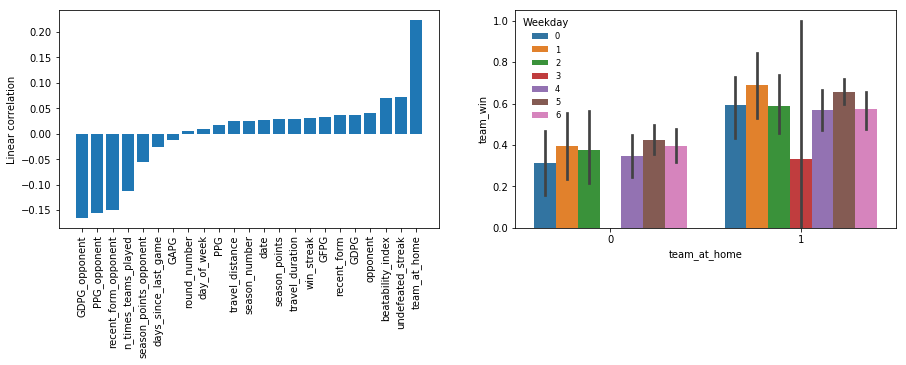

In [88]:
# Calculate correlation matrix then extract the correlations with respect to the win flag
corr_mat = df.corr()
correlation_with_win = corr_mat['team_win']
correlation_with_win = correlation_with_win[~np.isin(correlation_with_win.index.values, 
                                                     ['team_win', 'result', 'team_loss', 'team_draw',
                                                     'team_score', 'opposition_score'])]
correlation_with_win.sort_values(inplace=True)

# Plot these correlations
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15,4])
ax[0].bar(np.arange(len(correlation_with_win)), correlation_with_win)
ax[0].set_xticks(np.arange(len(correlation_with_win)))
ax[0].set_xticklabels(correlation_with_win.index.values, rotation=90)
ax[0].set_ylabel('Linear correlation')

# Plot a bar chart to see how home advantage and day of week affect the win rate
sns.barplot(data=df, x='team_at_home', y='team_win', hue='day_of_week', ax=ax[1])
ax[1].legend(loc=2, title='Weekday', fontsize='small', frameon=False)
plt.show()

So home advantage has the strongest linear relationship by a way, and appears to be most important on Fridays! Perhaps more interesting is that it matters more on Saturday (`weekday = 5`) than Sunday (`weekday = 6`)

**Effect of win/undefeated streaks**

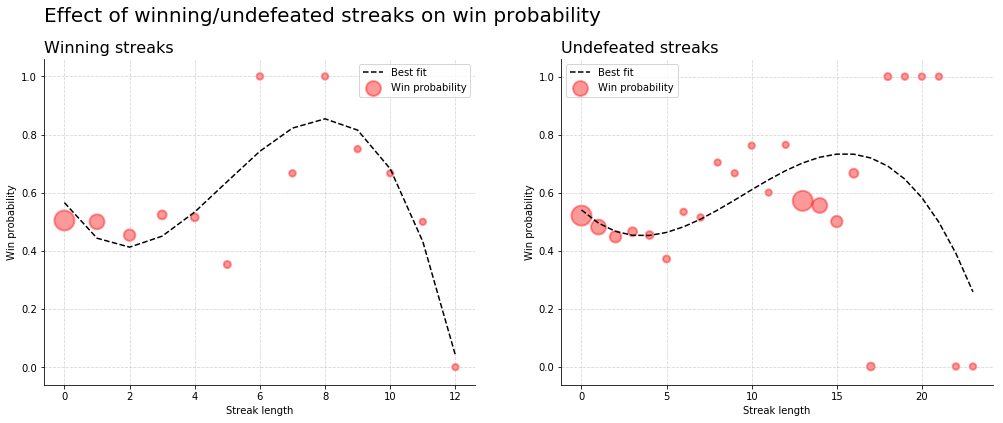

In [161]:
# Plot correlation between win/undefeated streaks and win likelihood
fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2, figsize=[17,6])

win_streak_effect = df.groupby('win_streak').agg({'team_win': ['mean', 'count']})
undef_streak_effect = df.groupby('undefeated_streak').agg({'team_win': ['mean', 'count']})
    
def plot_scatter(count_data, axes):
    
    rescaler = MinMaxScaler(feature_range=[40, 400])
    scaled_counts = rescaler.fit_transform(count_data['team_win']['count'].values.reshape(-1, 1))
    
    axes.scatter(
        count_data.index, 
        count_data['team_win']['mean'], 
        s=scaled_win_counts,
        c=(1, 0, 0, 0.4),
        edgecolor=(1, 0, 0, 1),
        lw=2,
        alpha=.4,
        label='Win probability'
    )
    
    degree = 3
    lm = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    lm.fit(count_data.index.values.reshape(-1, 1), count_data['team_win']['mean'])
    X_lm = np.arange(max(count_data.index) + 1)
    y_lm = lm.predict(X_lm.reshape(-1, 1))
    axes.plot(X_lm, y_lm, c='k', linestyle='--', label='Best fit')
    
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.set_ylabel('Win probability')
    axes.set_xlabel('Streak length')
    axes.grid(linestyle='--', alpha=.5)
    axes.legend(frameon=True)

plot_scatter(win_streak_effect, ax)
plot_scatter(undef_streak_effect, ax1)

plt.suptitle('Effect of winning/undefeated streaks on win probability', 
             horizontalalignment='left', x=.125, fontsize=20, y=1)
ax.set_title('Winning streaks', horizontalalignment='left', x=0, fontsize=16)
ax1.set_title('Undefeated streaks', horizontalalignment='left', x=0, fontsize=16)
plt.show()

For the above plots, the size of each point relates to how many observations there are at the given streak position. Interestingly, the data in both cases appears to fit to a 3rd degree polynomial.

Drop data that we can't use in training i.e. would leak the result

In [162]:
# E.g. goals scored and win flags used in the visualisations
df = processor.drop_features(df)
future_df = processor.drop_features(future_df)

### 3.4. Dimensionality reduction <a name="dimreduction"></a>

Although dimensionality reduction isn't strictly necessary, it is interesting to see if the fixtures cluster by result at all as an indication of how easy a model would be to make.

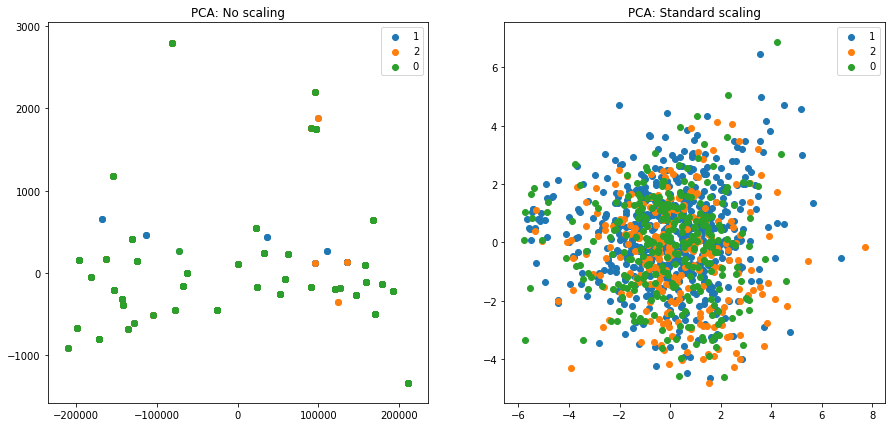

In [163]:
# PCA without scaling
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df.fillna(0))

# PCA with scaled variables
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df.fillna(0))
pca_sc = PCA(n_components=2)
scaled_pca = pca_sc.fit_transform(scaled_df)

# Plot the new datasets, colouring by result
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[15,7])

for result in df['result'].unique():
    result_mask = df['result'] == result
    ax0.scatter(X_pca[result_mask, 0], X_pca[result_mask, 1], label=result)
    
for result in df['result'].unique():
    result_mask = df['result'] == result
    ax1.scatter(scaled_pca[result_mask, 0], scaled_pca[result_mask, 1], label=result)
   
ax0.legend()
ax0.set_title('PCA: No scaling')
ax1.legend()
ax1.set_title('PCA: Standard scaling')

plt.show()

So it looks like with the current features it is difficult to separate results linearly.

### 3.5. Create a stratified test set <a name="split"></a>

Stratify by fixture result to maintain equal distributions of wins, draws & losses.

In [164]:
train, test, y_train, y_test, train_weight = processor.stratified_train_test(df)

## 4. Build a model <a name="train"></a>

Now the data is in good shape, the model can be trained

### 4.1. Class weights <a name="weights"></a>

In [165]:
# Add a class weight to the current date weight
# class_weights = {0: sum(y_train == 0)/len(y_train), 
#                  1: sum(y_train == 1)/len(y_train), 
#                  2: sum(y_train == 2)/len(y_train)}
# for class_ in np.unique(y_train):
#     train_weight[y_train == class_] = train_weight[y_train == class_] / class_weights[class_]

### 4.2. LightGBM API <a name="api"></a>

In [166]:
# Create a training set
categoricals = ['opponent', 'team_at_home', 'day_of_week']
lgbm_train_set = lgbm.Dataset(data=train, label=y_train, 
                              categorical_feature=categoricals, 
                              weight=train_weight,
                              free_raw_data=False)

# Set the training parameters
lgbm_params = {'application': 'multiclass',
               'booting': 'gbdt',
               'metric': 'multi_logloss',
               'training_metric': True,
               'learning_rate': 0.05,
               'feature_fraction': 0.8,
               'min_data_in_leaf': 30,
               'num_leaves': 31,
               'num_classes': 3}

### 4.3. Cross validation <a name="cv"></a>

In [167]:
cv = True
if cv:
    cv_results = lgbm.cv(train_set=lgbm_train_set, 
                         params=lgbm_params, 
                         nfold=5, 
                         verbose_eval=0, 
                         num_boost_round=100,
                         early_stopping_rounds=10)
    best_iteration = len(cv_results['multi_logloss-mean'])
    print('Number of boosting rounds = {:d}'.format(best_iteration))
    print('Mean log loss from best boosting round = {:.4f}'.format(cv_results['multi_logloss-mean'][-1]))

Number of boosting rounds = 35
Mean log loss from best boosting round = 1.0035


### 4.4 Train & evaluate <a name="eval"></a>

In [168]:
clf = lgbm.train(train_set=lgbm_train_set, 
                 params=lgbm_params,
                 num_boost_round=best_iteration)

In [169]:
y_prob = clf.predict(test, num_iteration=best_iteration)
y_pred = y_prob.argmax(axis=1)

LGBM accuracy = 0.43

LGBM classification report:

             precision    recall  f1-score   support

          0       0.21      0.10      0.14        29
          1       0.49      0.66      0.56        56
          2       0.35      0.30      0.32        27

avg / total       0.39      0.43      0.40       112



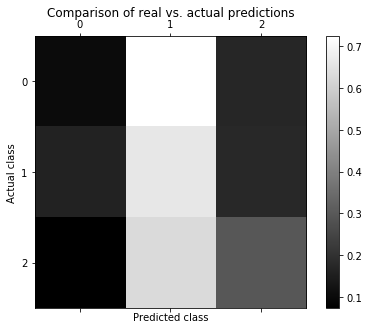

In [170]:
# Accuracy, precision & recall 
accuracy = accuracy_score(y_test, y_pred)
print('LGBM accuracy = {:.2f}\n'.format(accuracy))
print('LGBM classification report:\n')
print(classification_report(y_test, y_pred))

# Visualise the confusion matrix, normalised for classification frequency
conf_matrix = confusion_matrix(y_test, y_pred)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums
# np.fill_diagonal(norm_conf_matrix, 0)

fig, ax = plt.subplots(1, 1, figsize=[7,5])
conf_plot = ax.matshow(norm_conf_matrix, cmap=plt.cm.gray)
ax.set_xlabel('Predicted class')
ax.set_ylabel('Actual class')
ax.set_title('Comparison of real vs. actual predictions')
plt.colorbar(ax=ax, mappable=conf_plot)
plt.show()

In [171]:
print(np.histogram(y_pred, bins=[0, 1, 2, 3]))
print(np.histogram(y_test, bins=[0, 1, 2, 3]))

(array([14, 75, 23], dtype=int64), array([0, 1, 2, 3]))
(array([29, 56, 27], dtype=int64), array([0, 1, 2, 3]))


Lighter colors represent larger numbers in that position, so in this case we can see a lot of the errors are coming from draws (actual = 0) predicted to be wins (prediction = 1) in the centre-top position.

Second worst are losses predicted to be wins. This strongly indicates that winning predictions are the most wrong.

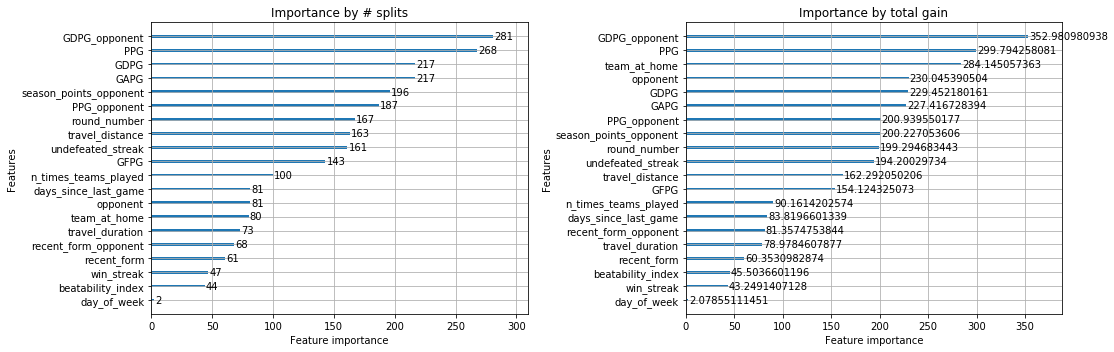

In [172]:
# Save model
clf.save_model(filename=os.path.join('models', 'lgbm_result_classifier.txt'))

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[15, 5])
lgbm.plot_importance(clf, ax=ax, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, importance_type='gain')

ax.set_title('Importance by # splits')
ax1.set_title('Importance by total gain')

plt.tight_layout()
plt.show()

## 5. Predict remaining PL games

In [173]:
# Next game features
future_df.sort_values(by='date', ascending=True, inplace=True)
future_dates = future_df.pop('date')
future_df.reset_index(drop=True, inplace=True)

Make prediction for each future row

In [174]:
future_predictions, future_probs = [], []
for i in range(len(future_df)):
    y_prob_f = clf.predict(future_df.loc[i, :])
    y_pred_f = y_prob_f.argmax(axis=1)
    future_predictions.append(y_pred_f)
    future_probs.append(y_prob_f)
    
    # Amend 'future' entries of the df with the predicted result
    if i < len(future_df) - 1:
        
        # If they win...
        if y_pred_f == 1:
            
            future_df.loc[i + 1, 'win_streak'] = future_df.loc[i, 'win_streak'] + 1
            future_df.loc[i + 1, 'undefeated_streak'] = future_df.loc[i, 'undefeated_streak'] + 1
            
            future_df.loc[i + 1, 'PPG'] = (future_df.loc[i, 'round_number'] * future_df.loc[i, 'PPG'] + 3) / \
                                           (future_df.loc[i, 'round_number'] + 1)
            
        # Draw...
        elif y_pred_f == 0:
            future_df.loc[i + 1, 'win_streak'] = 0
            future_df.loc[i + 1, 'undefeated_streak'] = future_df.loc[i, 'undefeated_streak'] + 1
            
            future_df.loc[i + 1, 'PPG'] = (future_df.loc[i, 'round_number'] * future_df.loc[i, 'PPG'] + 1) / \
                                           (future_df.loc[i, 'round_number'] + 1)
            
        # Lose...
        else:
            future_df.loc[i + 1, 'win_streak'] = 0
            future_df.loc[i + 1, 'undefeated_streak'] = 0   
            future_df.loc[i + 1, 'PPG'] = future_df.loc[i, 'round_number'] / (future_df.loc[i, 'round_number'] + 1) 

Output predictions as markdown to go into the wiki

In [175]:
print('| Date: Opposition | Win | Draw | Loss | | | |')
for i in range(len(future_df)):
    if future_df.loc[i, 'team_at_home']:
        home_flag = 'H'
    else:
        home_flag = 'A'
    print('| {:.4f}: {} ({})| {:.2f} | {:.2f} | {:.2f} |  |  |  | '\
          .format(future_dates.iloc[i], 
                  processor.opponent_encoder.inverse_transform(future_df.loc[i, 'opponent']), 
                  home_flag, 
                  100*future_probs[i][0][1], 
                  100*future_probs[i][0][0], 
                  100*future_probs[i][0][2]))

| Date: Opposition | Win | Draw | Loss | | | |
| 0.9761: Brighton & Hove Albion (H)| 54.25 | 31.70 | 14.05 |  |  |  | 
| 0.9768: Leicester City (A)| 36.03 | 41.34 | 22.62 |  |  |  | 
| 0.9781: Tottenham Hotspur (A)| 28.69 | 29.79 | 41.52 |  |  |  | 
| 0.9787: Southampton FC (H)| 36.22 | 26.11 | 37.68 |  |  |  | 
| 0.9794: Chelsea FC (A)| 32.03 | 18.43 | 49.54 |  |  |  | 
| 0.9801: Manchester City (H)| 26.90 | 20.34 | 52.76 |  |  |  | 
| 0.9813: Huddersfield Town (A)| 46.75 | 18.93 | 34.31 |  |  |  | 
| 0.9819: Cardiff City (H)| 47.12 | 17.19 | 35.69 |  |  |  | 
| 0.9826: Arsenal FC (A)| 27.73 | 37.82 | 34.45 |  |  |  | 
| 0.9833: Fulham FC (H)| 35.04 | 39.38 | 25.58 |  |  |  | 
| 0.9845: Watford FC (A)| 29.82 | 32.47 | 37.71 |  |  |  | 
| 0.9851: Everton FC (H)| 44.73 | 21.57 | 33.70 |  |  |  | 
| 0.9854: Burnley FC (A)| 47.27 | 16.69 | 36.04 |  |  |  | 
| 0.9857: AFC Bournemouth (A)| 32.40 | 24.77 | 42.83 |  |  |  | 
| 0.9864: Manchester United (H)| 32.33 | 29.07 | 38.60 |  |  |  | 
|

Feature contribution of next match

In [176]:
# feature_contributions = clf.predict(future_df.loc[0, :], pred_contrib=True)
# ind = np.arange(len(clf.feature_importance()))

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15,5])
# ax[0].bar(ind, clf.feature_importance())
# ax[1].bar(ind, feature_contributions.ravel()[:-1])
# for axs in ax:
#     axs.set_xticks(np.arange(len(clf.feature_importance())))
#     axs.set_xticklabels(clf.feature_name(), rotation=90)
# plt.show()

In [177]:
# Calculate log loss of prediction given actual result
from sklearn.metrics import log_loss

y_actual_live = np.array([[1, 0, 0]])
y_prob_live = np.array([[.3899, .3567, .2534]])
log_loss(y_actual_live, y_prob_live)

0.94186498299358534